See [README.md](https://github.com/druce/portfolio_optimization/blob/master/README.md) for discussion, environment setup


In [1]:
import time
import urllib3
from collections import namedtuple

# from multiprocessing import Pool

from typing import Callable, List, Any, Tuple
from typing import Optional, Union
import numpy.typing as npt

import numpy as np
import pandas as pd
import pandas_datareader as pdr

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cvxpy as cp

# Set seed for reproducibility
np.random.seed(42)

# Display versions
print(f"{'numpy':<20} {np.__version__}")
print(f"{'pandas':<20} {pd.__version__}")
print(f"{'pandas-datareader':<20} {pdr.__version__}")
print(f"{'seaborn':<20} {sns.__version__}")
print(f"{'matplotlib':<20} {matplotlib.__version__}")
print(f"{'cvxpy':<20} {cp.__version__}")


numpy                2.3.5
pandas               2.3.3
pandas-datareader    0.10.0
seaborn              0.13.2
matplotlib           3.10.7
cvxpy                1.7.3


# Helper Functions


In [2]:
def fetch_with_retry(fetch_func: Callable[[], Any], max_retries: int = 3, delay: int = 2) -> Any:
    """
    Fetch data with retry logic.

    Attempts to execute the provided fetch function with automatic retries
    on failure, using exponential backoff between attempts.

    Parameters
    ----------
    fetch_func : Callable[[], Any]
        Function that fetches data (takes no arguments)
    max_retries : int, default=3
        Maximum number of retry attempts
    delay : int, default=2
        Delay in seconds between retries

    Returns
    -------
    Any
        Result returned by fetch_func

    Raises
    ------
    Exception
        Re-raises the last exception if all retry attempts fail
    """
    for attempt in range(max_retries):
        try:
            return fetch_func()
        except Exception as e:
            if attempt == max_retries - 1:
                raise
            print(f"Attempt {attempt + 1} failed: {e}. Retrying in {delay}s...")
            time.sleep(delay)


def validate_data(df: pd.DataFrame, required_columns: List[str]) -> None:
    """
    Validate DataFrame has required columns and no NaN/Inf values.

    Checks for missing columns, NaN values, and infinite values in the
    specified columns of the DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to validate
    required_columns : List[str]
        List of required column names to check

    Returns
    -------
    None

    Raises
    ------
    ValueError
        If required columns are missing, NaN values are found, or
        infinite values are detected
    """
    # Check for missing columns
    missing = set(required_columns) - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Check for NaN values
    if df[required_columns].isna().any().any():
        nan_cols = df[required_columns].columns[df[required_columns].isna().any()].tolist()
        n_missing = df[required_columns].isna().sum()
        raise ValueError(f"Warning: {n_missing} NaN values found in columns: {nan_cols}")

    # Check for infinite values
    if np.isinf(df[required_columns].values).any():
        raise ValueError("Infinite values found in data")

def compute_historical_metrics(df: pd.DataFrame, weights: npt.NDArray[np.float64], geometric: bool = False) -> Tuple[float, float]:
    # Compute historical portfolio returns (time series of annual returns)
    portfolio_returns = df @ weights

    if geometric:
        # Geometric mean (CAGR): (product of (1 + r))^(1/n) - 1
        mean_return = (np.prod(1 + portfolio_returns) ** (1 / len(portfolio_returns))) - 1
    else:
        mean_return = portfolio_returns.mean()

    return mean_return, portfolio_returns.std()

def add_historical_metrics(ret_df: pd.DataFrame, df: pd.DataFrame, asset_columns: List[str]) -> pd.DataFrame:
    """
    Add historical return and standard deviation columns based on actual portfolio performance.

    Computes what each efficient frontier portfolio would have actually returned
    historically, using geometric mean (CAGR) and standard deviation of percentage returns.
    Adds 'hist_return' and 'hist_std' columns to the input DataFrame.

    Parameters
    ----------
    ret_df : pd.DataFrame
        Efficient frontier results with model-based returns and asset weight columns
    df : pd.DataFrame
        Historical percentage returns data (for validation/plotting)
    asset_columns : List[str]
        Asset column names in order matching the weights in ret_df

    Returns
    -------
    pd.DataFrame
        Copy of ret_df with added columns:
        - hist_return : float - Geometric mean (CAGR) of portfolio returns
        - hist_std : float - Standard deviation of percentage portfolio returns
    """
    hist_returns = []
    hist_stds = []

    for i in ret_df.index:
        weights = ret_df.loc[i, asset_columns].values
        mean_return, std_dev = compute_historical_metrics(df[asset_columns], weights, geometric=True)
        hist_returns.append(mean_return)
        hist_stds.append(std_dev)

    ret_df = ret_df.copy()
    ret_df['hist_return'] = hist_returns
    ret_df['hist_std'] = hist_stds

    return ret_df

In [3]:
OptimizationResult = namedtuple('OptimizationResult', ['return_val', 'std_dev', 'weights'])

def solve_portfolio_optimization(params: Tuple[float, npt.NDArray[np.float64], npt.NDArray[np.float64], int]) -> OptimizationResult:
    """
    Solve portfolio optimization for given parameters using convex optimization.

    Maximizes portfolio return subject to volatility constraint and long-only
    constraint. This is a standalone function that can be pickled for multiprocessing.

    Parameters
    ----------
    params : Tuple[float, npt.NDArray[np.float64], npt.NDArray[np.float64], int]
        Tuple containing (vol_limit, mu, Sigma, n) where:
        - vol_limit : float - Volatility (variance) limit constraint
        - mu : npt.NDArray[np.float64] - Expected returns vector
        - Sigma : npt.NDArray[np.float64] - Covariance matrix
        - n : int - Number of assets

    Returns
    -------
    OptimizationResult
        Named tuple with fields:
        - return_val : float - Optimized portfolio return
        - std_dev : float - Portfolio standard deviation
        - weights : npt.NDArray[np.float64] - Asset weights

    Raises
    ------
    ValueError
        If optimization fails, returns None values, or weights don't sum to 1.0
    """
    vol_limit, mu, Sigma, n = params

    # Create optimization variables and problem
    w = cp.Variable(n)
    ret = mu.T @ w
    vol = cp.quad_form(w, Sigma)

    prob = cp.Problem(
        cp.Maximize(ret),
        [cp.sum(w) == 1, w >= 0, vol <= vol_limit]
    )

    result = prob.solve(
        solver=cp.CLARABEL,
        tol_feas=1e-10,      # Feasibility tolerance (default: 1e-8)
        tol_gap_abs=1e-10,   # Absolute duality gap tolerance (default: 1e-8)
        tol_gap_rel=1e-9,    # Relative duality gap tolerance (default: 1e-8)
        max_iter=200         # Max iterations (default: 50)
    )

    if prob.status not in ['optimal', 'optimal_inaccurate']:
        raise ValueError(
                 f"Optimization failed with status '{prob.status}' for vol_limit={vol_limit}. "
                 f"Problem may be infeasible or solver encountered an error."
             )

    # Validate results exist
    if ret.value is None or vol.value is None or w.value is None:
        raise ValueError(f"Optimization returned None values for vol_limit={vol_limit}.")

    # Validate weights sum to 1.0 (within numerical precision)
    weight_sum = w.value.sum()
    if abs(weight_sum - 1.0) > WEIGHT_SUM_TOLERANCE:
        raise ValueError(f"Weights sum to {weight_sum:.6f}, not 1.0. Check constraints.")

    return OptimizationResult(
        return_val=ret.value,
        std_dev=np.sqrt(vol.value),
        weights=w.value
    )


In [4]:
PortfolioMetrics = namedtuple('PortfolioMetrics', ['max_sharpe_return', 'max_sharpe_std', 'avg_ef_return', 'avg_ef_std'])

def plot_efrontier(plot_ef_df: pd.DataFrame,
                   plot_returns_df: pd.DataFrame,
                   assets_df: pd.DataFrame,
                   xlabel: str = "Standard Deviation of Real Returns",
                   ylabel: str = "Real Return",
                   title: Optional[str] = None,
                   risk_free_rate: float = 0) -> PortfolioMetrics:
    """
    Plot efficient frontier with individual assets and key portfolios.

    Creates a visualization of the efficient frontier showing the risk-return
    tradeoff, individual asset positions, maximum Sharpe ratio portfolio, and
    average efficient frontier portfolio. Prints detailed statistics for key
    portfolios.

    Parameters
    ----------
    plot_ef_df : pd.DataFrame
        Efficient frontier scenarios with columns:
        - Asset weight columns (one per asset)
        - 'hist_return' : historical portfolio returns
        - 'hist_std' : historical portfolio standard deviation
    plot_returns_df : pd.DataFrame
        Historical asset returns data with asset columns
    xlabel : str, default="Standard Deviation of Real Returns"
        X-axis label for the plot
    ylabel : str, default="Real Return"
        Y-axis label for the plot
    title : Optional[str], default=None
        Plot title. If None, auto-generated from date range in df
    risk_free_rate : float, default=0
        Risk-free rate for Sharpe ratio calculation

    Returns
    -------
    PortfolioMetrics
        Named tuple with fields:
        - max_sharpe_return : float - Return of max Sharpe ratio portfolio
        - max_sharpe_std : float - Std dev of max Sharpe ratio portfolio
        - avg_ef_return : float - Mean return of average EF portfolio
        - avg_ef_std : float - Std dev of average EF portfolio

    Notes
    -----
    - Calculates Sharpe ratios for all portfolios on efficient frontier
    - Highlights maximum Sharpe ratio portfolio with red star marker
    - Shows average efficient frontier portfolio with green circle marker
    - Displays individual asset positions as gray dots
    - Prints portfolio weights for assets with >0.1% allocation
    """

    asset_labels = list(assets_df.index)

    mu = assets_df['ret'].values
    asset_vols = assets_df['std'].tolist()

    plot_ef_df["Sharpe"] = np.where(
        plot_ef_df["hist_std"] > MIN_VOL_FOR_SHARPE,  # Avoid division by near-zero
        (plot_ef_df["hist_return"] - risk_free_rate) / plot_ef_df["hist_std"],
        np.nan  # Return NaN for zero volatility
    )

    # Find max Sharpe portfolio
    max_sharpe_index = plot_ef_df["Sharpe"].idxmax()
    max_sharpe_return = plot_ef_df.loc[max_sharpe_index, "hist_return"]
    max_sharpe_std = plot_ef_df.loc[max_sharpe_index, "hist_std"]
    max_sharpe_ratio = plot_ef_df.loc[max_sharpe_index, "Sharpe"]

    # Find 'midwit' portfolio averaging weights over whole frontier

    def compute_historical_metrics(df: pd.DataFrame, weights: npt.NDArray[np.float64]) -> Tuple[float, float]:
        # Compute historical portfolio returns (time series of annual returns)
        portfolio_returns = df @ weights
        return portfolio_returns.mean(), portfolio_returns.std()

    mean_wts = plot_ef_df[asset_labels].mean()
    ret_series = plot_returns_df[asset_labels] @ mean_wts.values
    avg_ret_mean = (ret_series + 1).prod() ** (1/len(ret_series)) - 1
    avg_ret_std = ret_series.std()

    # Create plot
    plt.figure(figsize=(8, 4.5))

    # Plot efficient frontier
    plt.plot(plot_ef_df['hist_std'], plot_ef_df['hist_return'], label='Efficient frontier', linewidth=2)

    plt.xlim(left=0, right=max(asset_vols) * 1.05)
    plt.ylim(bottom=min(0, min(mu)))

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # fix df
    plot_title = f"Risk vs. Real Return, {df.index[0]}-{df.index[-1]}" if title is None else title
    plt.title(plot_title)

    # Plot individual assets
    plt.scatter(asset_vols, mu, color='gray', s=50, zorder=5)
    xoffset = 0.0025
    yoffset = 0.0015

    for i, label in enumerate(asset_labels):
        plt.annotate(label, xy=(asset_vols[i] + xoffset, mu[i] + yoffset),
                    xycoords='data', horizontalalignment='left',
                    verticalalignment='top')


    # Plot max Sharpe portfolio (model)
    plt.scatter([max_sharpe_std], [max_sharpe_return], color='red', s=100,
               marker='*', label='Max Sharpe', zorder=10)
    plt.annotate("Max Sharpe", xy=(max_sharpe_std + xoffset, max_sharpe_return + yoffset),
                xycoords='data', horizontalalignment='left',
                verticalalignment='top', fontsize=9)

    # Plot average EF portfolio
    plt.scatter([avg_ret_std], [avg_ret_mean], color='green', s=80,
               marker='o', label='EF Avg Wts', zorder=10)
    plt.annotate("EF Avg Wts", xy=(avg_ret_std + xoffset, avg_ret_mean + yoffset),
                xycoords='data', horizontalalignment='left',
                verticalalignment='top', fontsize=9)

    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.show()

    # Print statistics
    print("="*60)
    print("Max Sharpe Portfolio:")
    print(f"Real Return:  {100 * max_sharpe_return:3.2f}%")
    print(f"SD:           {100 * max_sharpe_std:3.2f}%")
    print(f"Sharpe Ratio: {max_sharpe_ratio:3.3f}")
    for col in asset_labels:
        wt = plot_ef_df.loc[max_sharpe_index, col]
        if wt > MIN_DISPLAY_WEIGHT:
            print(f"{col}: {100*wt:3.1f}%")

    print("="*60)
    print("Average over entire efficient frontier:")
    print(f"Real Return:  {100 * avg_ret_mean:3.2f}%")
    print(f"SD:           {100 * avg_ret_std:3.2f}%")
    print(f"Sharpe Ratio: {avg_ret_mean / avg_ret_std:3.3f}")
    for col in asset_labels:
        wt = mean_wts[col]
        if wt > MIN_DISPLAY_WEIGHT:
            print(f"{col}: {100*wt:3.1f}%")
    print("="*60)

    return PortfolioMetrics(
        max_sharpe_return=max_sharpe_return,
        max_sharpe_std=max_sharpe_std,
        avg_ef_return=avg_ret_mean,
        avg_ef_std=avg_ret_std
    )


In [5]:
# stacked area chart of weights vs. returns
# for given vol constraint and corresponding real return, show portfolio weights
def transition_map(ret_df: pd.DataFrame, asset_labels: Union[List[str], pd.Index],
                  startyear: int, endyear: int,
                  max_sharpe_return: Optional[float] = None, ylim: float = 1) -> None:
    """
    Create transition map showing portfolio weights across return levels.

    Displays a stacked area chart showing how optimal portfolio weights change
    across different target return levels along the efficient frontier.

    Parameters
    ----------
    ret_df : pd.DataFrame
        Efficient frontier results containing asset weight columns and
        'hist_return' column
    asset_labels : Union[List[str], pd.Index]
        Asset column names to display in the transition map
    startyear : int
        Start year for plot title
    endyear : int
        End year for plot title
    max_sharpe_return : Optional[float], default=None
        Return of max Sharpe ratio portfolio. If provided, draws a vertical
        dashed line at this return level
    ylim : float, default=1
        Y-axis upper limit (portfolio weights sum to 1.0)

    Returns
    -------
    None
        Displays matplotlib plot but returns nothing

    Notes
    -----
    - Uses tab20 colormap for up to 10 assets
    - X-axis shows portfolio return levels
    - Y-axis shows portfolio weight allocation (0 to ylim)
    - Stacked areas show weight allocation to each asset
    """
    x = ret_df['hist_return']
    y_list = [ret_df[label] for label in asset_labels]

    # Generate colors dynamically based on number of assets
    colors = cm.tab20.colors[:len(asset_labels)]

    fig = plt.figure(figsize=(8, 4.5))
    ax1 = fig.add_subplot(111)

    ax1.stackplot(x, y_list, labels=asset_labels, colors=colors)
    ax1.set_xlim((ret_df['hist_return'].iloc[0], ret_df['hist_return'].iloc[-1]))
    ax1.set_ylim((0, ylim))
    ax1.set_xlabel("Portfolio Real Return")
    ax1.set_ylabel("Portfolio Weight")
    ax1.legend(loc='lower right')

    if max_sharpe_return is not None:
        ax1.axvline(max_sharpe_return, color='black', linestyle='--', linewidth=1)

    plt.title(f"Optimal Portfolio Transition Map, {startyear}-{endyear}", y=1.16)
    plt.show()


In [6]:
# Data source configuration
DATA_XLS = 'https://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls'
DATA_SHEET = "Returns by year"

# Damodaran data structure constants (as of 2025)
DAMODARAN_HEADER_ROWS = 19  # Rows before data starts
DAMODARAN_FOOTER_ROWS = 13  # Footnote rows at end

# Manual GDP data for years not in FRED (source: fortunly.com)
MANUAL_GDP_DATA = {
    1928: 0.0110,
    1929: 0.0652,
}

# Optimization parameters
NPOINTS = 200  # Points on efficient frontier
USE_PARALLEL = False  # Enable parallel processing, doesn't work under Jupyter
NPROCESSES = 8  # Number of parallel processes

# Other constants
WEIGHT_SUM_TOLERANCE = 1e-4
MIN_VOL_FOR_SHARPE = 1e-10
MIN_DISPLAY_WEIGHT = 0.001

# Get data

In [7]:
# Data source configuration
DATA_XLS = 'https://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls'
DATA_SHEET = "Returns by year"

# Damodaran data structure constants (as of 2025)
DAMODARAN_HEADER_ROWS = 19  # Rows before data starts
DAMODARAN_FOOTER_ROWS = 13  # Footnote rows at end

# Manual GDP data for years not in FRED (source: fortunly.com)
MANUAL_GDP_DATA = {
    1928: 0.0110,
    1929: 0.0652,
}

# Optimization parameters
NPOINTS = 200  # Points on efficient frontier
USE_PARALLEL = False  # Enable parallel processing, doesn't work under Jupyter
NPROCESSES = 8  # Number of parallel processes


In [8]:
# Load spreadsheet from Damodaran website

# Disable SSL certificate verification if necessary
# previously noticed this issue with the Damodaran website
# urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

download_df = fetch_with_retry(
    lambda: pd.read_excel(
        DATA_XLS,
        sheet_name=DATA_SHEET,
        skiprows=range(DAMODARAN_HEADER_ROWS),
        skipfooter=DAMODARAN_FOOTER_ROWS
    )
)

download_df.head()

,Year,S&P 500 (includes dividends),US Small cap (bottom decile),3-month T.Bill,US T. Bond (10-year),Baa Corporate Bond,Real Estate,Gold*,S&P 500 (includes dividends)3,US Small cap (bottom decile) Cum Value,...,Gold,S&P 500 (includes dividends)3.1,US Small cap (bottom decile)22.1,3-month T.Bill4.1,US T. Bond5.1,Baa Corporate Bond2.1,Real Estate2.1,Gold2.1,Stocks minus T. Bills,Stocks minus T.Bonds
0,1928,0.438112,0.5991,0.0308,0.008355,0.032196,0.014911,0.000969,143.811155,159.910000,...,0.012676,145.493158,161.780293,104.285615,102.014834,104.426798,102.678084,101.267624,0.412075,0.434783
1,1929,-0.082979,-0.4661,0.0316,0.042038,0.030179,-0.020568,-0.001452,131.877782,85.375949,...,-0.007258,132.644508,85.872317,106.955564,105.685290,106.952789,99.981502,100.532660,-0.113913,-0.124291
2,1930,-0.251236,-0.5003,0.0455,0.045409,0.005398,-0.043000,0.000969,98.745288,42.662362,...,0.069359,106.105182,45.842164,119.462059,118.033011,114.876878,102.219599,107.505474,-0.317010,-0.316913
3,1931,-0.438375,-0.4466,0.0231,-0.025589,-0.156808,-0.081505,-0.173850,55.457774,23.609351,...,-0.088971,65.713662,27.975463,134.778649,126.829091,106.815001,103.534271,97.940557,-0.508887,-0.455197
4,1932,-0.086424,0.2049,0.0107,0.087903,0.235896,-0.104664,0.212778,50.664911,28.446907,...,0.351646,66.908619,37.567287,151.818576,153.776732,147.128135,103.312182,132.380976,-0.108245,-0.194288


In [9]:
# set index to year as int
download_df["Year"] = download_df["Year"].astype(int)
download_df.set_index(download_df["Year"], inplace=True)
download_df.head()


,Year,S&P 500 (includes dividends),US Small cap (bottom decile),3-month T.Bill,US T. Bond (10-year),Baa Corporate Bond,Real Estate,Gold*,S&P 500 (includes dividends)3,US Small cap (bottom decile) Cum Value,...,Gold,S&P 500 (includes dividends)3.1,US Small cap (bottom decile)22.1,3-month T.Bill4.1,US T. Bond5.1,Baa Corporate Bond2.1,Real Estate2.1,Gold2.1,Stocks minus T. Bills,Stocks minus T.Bonds
Year,,,,,,,,,,,,,,,,,,,,,
1928,1928,0.438112,0.5991,0.0308,0.008355,0.032196,0.014911,0.000969,143.811155,159.910000,...,0.012676,145.493158,161.780293,104.285615,102.014834,104.426798,102.678084,101.267624,0.412075,0.434783
1929,1929,-0.082979,-0.4661,0.0316,0.042038,0.030179,-0.020568,-0.001452,131.877782,85.375949,...,-0.007258,132.644508,85.872317,106.955564,105.685290,106.952789,99.981502,100.532660,-0.113913,-0.124291
1930,1930,-0.251236,-0.5003,0.0455,0.045409,0.005398,-0.043000,0.000969,98.745288,42.662362,...,0.069359,106.105182,45.842164,119.462059,118.033011,114.876878,102.219599,107.505474,-0.317010,-0.316913
1931,1931,-0.438375,-0.4466,0.0231,-0.025589,-0.156808,-0.081505,-0.173850,55.457774,23.609351,...,-0.088971,65.713662,27.975463,134.778649,126.829091,106.815001,103.534271,97.940557,-0.508887,-0.455197
1932,1932,-0.086424,0.2049,0.0107,0.087903,0.235896,-0.104664,0.212778,50.664911,28.446907,...,0.351646,66.908619,37.567287,151.818576,153.776732,147.128135,103.312182,132.380976,-0.108245,-0.194288


In [10]:
# Download GDP data from FRED
gdp_download = fetch_with_retry(
    lambda: pdr.data.DataReader(['GDPCA'], 'fred', start='1926-12-31')
)

gdp_download.reset_index(inplace=True)
gdp_download.set_index(pd.DatetimeIndex(gdp_download['DATE']).year, inplace=True)
gdp_download['GDP'] = gdp_download['GDPCA'].pct_change()

# Fill in manual GDP data for early years
for year, value in MANUAL_GDP_DATA.items():
    gdp_download.loc[year, 'GDP'] = value

gdp_download.sort_index(inplace=True)
gdp_download.to_csv('gdp_fred.csv')

gdp_download

,DATE,GDPCA,GDP
DATE,,,
1928,NaT,NaN,0.011000
1929,1929-01-01,1191.124,0.065200
1930,1930-01-01,1089.785,-0.085078
1931,1931-01-01,1019.977,-0.064057
1932,1932-01-01,888.414,-0.128986
...,...,...,...
2020,2020-01-01,20284.500,-0.020814
2021,2021-01-01,21532.407,0.061520
2022,2022-01-01,22075.931,0.025242


In [11]:
# Preview columns
print("Available columns:")
for col in download_df.columns:
    print(f"  {col}")
    

Available columns:
  Year
  S&P 500 (includes dividends)
  US Small cap (bottom decile)
  3-month T.Bill
  US T. Bond (10-year)
   Baa Corporate Bond
  Real Estate
  Gold*
  S&P 500 (includes dividends)3
  US Small cap (bottom decile) Cum Value
  3-month T.Bill4
  US T. Bond5
   Baa Corporate Bond2
  Real Estate2
  Gold2
  Stocks - Bills
  Stocks - Bonds
  Small Cap Premium (S&P 500 minus Bottom Decile)
  Stocks - Baa Corp Bond
  Historical ERP
  Inflation Rate
  S&P 500 (includes dividends)2
  US Small cap (bottom decile)22
  3-month T. Bill (Real)
  !0-year T.Bonds
  Baa Corp Bonds
  Real Estate3
  Gold
  S&P 500 (includes dividends)3.1
  US Small cap (bottom decile)22.1
  3-month T.Bill4.1
  US T. Bond5.1
   Baa Corporate Bond2.1
  Real Estate2.1
  Gold2.1
  Stocks minus T. Bills
  Stocks minus T.Bonds


In [12]:
# Extract and rename columns for real returns
# Note: Column names may have quirky characters in source (e.g., '!0-year' instead of '10-year')

plot_returns_df = download_df.copy()

# Drop nominal real estate column to avoid confusion
if "Real Estate" in plot_returns_df.columns:
    plot_returns_df = plot_returns_df.drop(columns=["Real Estate"])

# Define column rename mapping
rename_map = {
    'Inflation Rate': 'CPI',
    'S&P 500 (includes dividends)2': 'S&P',
    "US Small cap (bottom decile)22": "Small Caps",
    '3-month T. Bill (Real)': 'T-Bills',
    '!0-year T.Bonds': 'T-Notes',
    'Baa Corp Bonds': 'Baa Corps',
    'Real Estate3': 'Real Estate',
}

# Check if all names in rename_map are present in columns
missing_names = set(rename_map.keys()) - set(plot_returns_df.columns)
if missing_names:
    raise ValueError(f"Names {missing_names} not found in real_return_df columns")

# Rename columns
plot_returns_df = plot_returns_df.rename(columns=rename_map)

# Add GDP data
plot_returns_df["GDP"] = gdp_download['GDP']

# Select, reorder columns, and validate data
required_columns = ['GDP', 'CPI', 'S&P', 'Small Caps', 'T-Bills',
                   'T-Notes', 'Baa Corps', 'Real Estate', 'Gold']

validate_data(plot_returns_df, required_columns)
plot_returns_df = plot_returns_df[required_columns]

plot_returns_df


,GDP,CPI,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,,,
1928,0.011000,-0.011561,0.454932,0.617803,0.042856,0.020148,0.044268,0.026781,0.012676
1929,0.065200,0.005848,-0.088311,-0.469204,0.025602,0.035980,0.024189,-0.026262,-0.007258
1930,-0.085078,-0.063953,-0.200079,-0.466159,0.116932,0.116835,0.074090,0.022385,0.069359
1931,-0.064057,-0.093168,-0.380674,-0.389744,0.128213,0.074522,-0.070178,0.012861,-0.088971
1932,-0.128986,-0.102740,0.018184,0.342866,0.126429,0.212472,0.377411,-0.002145,0.351646
...,...,...,...,...,...,...,...,...,...
2020,-0.020814,0.013620,0.164373,0.329196,-0.009937,0.098359,0.091150,0.089428,0.225009
2021,0.061520,0.070364,0.200235,0.136903,-0.065318,-0.106996,-0.057018,0.110507,-0.100815
2022,0.025242,0.064544,-0.230069,-0.280255,-0.041611,-0.228103,-0.202889,-0.007539,-0.055470


In [13]:
total_return_index_df = (plot_returns_df+1).cumprod()
total_return_index_df.loc[1927] = 1
total_return_index_df = total_return_index_df.sort_index()
total_return_index_df

,GDP,CPI,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,,,
1927,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1928,1.011000,0.988439,1.454932,1.617803,1.042856,1.020148,1.044268,1.026781,1.012676
1929,1.076917,0.994220,1.326445,0.858723,1.069556,1.056853,1.069528,0.999815,1.005327
1930,0.985295,0.930636,1.061052,0.458422,1.194621,1.180330,1.148769,1.022196,1.075055
1931,0.922180,0.843931,0.657137,0.279755,1.347786,1.268291,1.068150,1.035343,0.979406
...,...,...,...,...,...,...,...,...,...
2020,18.339591,15.056293,393.798650,2860.019096,1.392829,5.925031,35.319862,2.666225,6.085366
2021,19.467847,16.115714,472.650989,3251.564176,1.301852,5.291078,33.306010,2.960860,5.471873
2022,19.959257,17.155887,363.908433,2340.296382,1.247681,4.084167,26.548570,2.938538,5.168350


In [14]:
# Compute geometric mean returns
n_periods = len(total_return_index_df) - 1
geometric_mean = pd.DataFrame(total_return_index_df.iloc[-1] ** (1 / n_periods) - 1)
geometric_mean.columns=['Ret']

# Compute std of real_return_df
real_return_std = pd.DataFrame(plot_returns_df.std())
real_return_std.columns=['STD']

# Combine geometric mean and std
geometric_mean = pd.concat([geometric_mean, real_return_std], axis=1)

print("Geometric mean returns with STD:")
geometric_mean

Geometric mean returns with STD:


,Ret,STD
GDP,0.031945,0.047254
CPI,0.030374,0.039154
S&P,0.067000,0.193954
Small Caps,0.084081,0.372102
T-Bills,0.002675,0.038017
T-Notes,0.014209,0.088987
Baa Corps,0.034818,0.088440
Real Estate,0.011557,0.049934
Gold,0.020178,0.186131


# Exploratory Data Analysis

In [15]:
pd.set_option('display.max_rows', None)  # display all rows without truncation
pd.set_option('display.float_format', '{:.6f}'.format) # don't use scientific notation


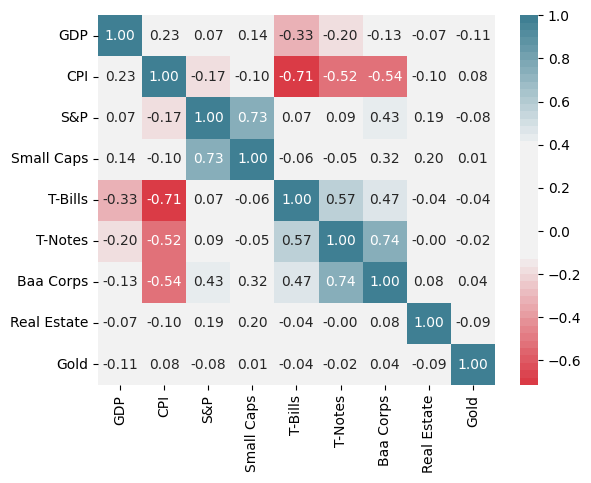

In [16]:
for col in plot_returns_df.columns:
    plot_returns_df[col] = plot_returns_df[col].astype(float)

# compute correlation matrix
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(plot_returns_df.corr(), annot=True, fmt=".02f", cmap=my_cmap);


In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
from scipy import stats
import pyperclip

# Get S&P returns
sp_returns = plot_returns_df['S&P']

# Calculate statistics
mean = sp_returns.mean()
std = sp_returns.std()
median = sp_returns.median()

# Create histogram data
hist_data = sp_returns.values

# Generate normal distribution curve
x_range = np.linspace(sp_returns.min() - 0.1, sp_returns.max() + 0.1, 200)
normal_curve = stats.norm.pdf(x_range, mean, std)

# Scale the normal curve to match histogram with 10 bins
nbins = 10
bin_width = (sp_returns.max() - sp_returns.min()) / nbins
scale_factor = len(sp_returns) * bin_width
normal_curve_scaled = normal_curve * scale_factor

# Create figure
fig = go.Figure()

# Add histogram
fig.add_trace(go.Histogram(
    x=hist_data,
    name='S&P Returns',
    nbinsx=nbins,
    opacity=0.7,
    marker_color='lightblue',
    marker_line_color='darkblue',
    marker_line_width=1,
    hovertemplate='Return Range: %{x}<br>Count: %{y}<extra></extra>',
    showlegend=False
))

# Add normal distribution curve
fig.add_trace(go.Scatter(
    x=x_range,
    y=normal_curve_scaled,
    name='Normal Distribution',
    line=dict(color='red', width=3),
    mode='lines',
    hovertemplate='Return: %{x:.2%}<br>Density: %{y:.2f}<extra></extra>',
    showlegend=False
))

# Add individual year markers with jittered y-positions
np.random.seed(42)  # For reproducible jitter

# Get years and returns
years = sp_returns.index.values
returns = sp_returns.values

# Sort by return to help with visibility
sorted_indices = np.argsort(returns)
years_sorted = years[sorted_indices]
returns_sorted = returns[sorted_indices]

# Redistribute y-positions to avoid overlap in same bin
bin_edges = np.histogram(returns, bins=nbins)[1]
y_jittered = []
for ret in returns_sorted:
    # Find which bin this return falls into
    bin_idx = np.digitize(ret, bin_edges) - 1
    # Count how many points are already in this bin
    points_in_bin = sum(1 for r, y in zip(returns_sorted[:len(y_jittered)], y_jittered) 
                       if np.digitize(r, bin_edges) - 1 == bin_idx)
    # Stack vertically with some jitter
    y_pos = 0.2 + (points_in_bin % 8) * 0.3 + np.random.uniform(-0.1, 0.1)
    y_jittered.append(y_pos)

fig.add_trace(go.Scatter(
    x=returns_sorted,
    y=y_jittered,
    mode='markers',
    name='Individual Years',
    marker=dict(
        size=8,
        color=returns_sorted,
        colorscale='RdYlGn',
        showscale=False,
        line=dict(width=1, color='DarkSlateGrey'),
        opacity=0.8
    ),
    text=[f"{year}" for year in years_sorted],
    customdata=np.column_stack((years_sorted, returns_sorted)),
    hovertemplate='<b>Year %{customdata[0]}</b><br>' +
                  'Return: %{customdata[1]:.2%}<extra></extra>',
    showlegend=False
))

# Add mean line
fig.add_vline(
    x=mean,
    line_dash="dash",
    line_color="green",
    annotation_text=f"Mean: {mean:.2%}",
    annotation_position="top"
)

# Add median line
fig.add_vline(
    x=median,
    line_dash="dot",
    line_color="orange",
    annotation_text=f"Median: {median:.2%}",
    annotation_position="bottom"
)

# Update layout
fig.update_layout(
    title=dict(
        text=f'Distribution of S&P 500 Real Returns (1928-2024)<br><sub>Mean: {mean:.2%}, Std Dev: {std:.2%}</sub>',
        x=0.5,
        xanchor='center'
    ),
    xaxis_title='Annual Real Return',
    yaxis_title='Frequency',
    showlegend=False,
    template='plotly_white',
    hovermode='closest',
    height=600,
    xaxis=dict(tickformat='.0%')
)

# Add annotation with statistics
fig.add_annotation(
    text=(
        f'<b>Statistics:</b><br>'
        f'Mean: {mean:.2%}<br>'
        f'Median: {median:.2%}<br>'
        f'Std Dev: {std:.2%}<br>'
        f'Min: {sp_returns.min():.2%} ({sp_returns.idxmin()})<br>'
        f'Max: {sp_returns.max():.2%} ({sp_returns.idxmax()})<br>'
        f'Skewness: {sp_returns.skew():.2f}<br>'
        f'Kurtosis: {sp_returns.kurtosis():.2f}'
    ),
    xref="paper", yref="paper",
    x=0.98, y=0.98,
    xanchor='right', yanchor='top',
    showarrow=False,
    bordercolor="black",
    borderwidth=1,
    borderpad=10,
    bgcolor="white",
    opacity=0.9
)

fig.show()

html_str = pyo.plot(fig, include_plotlyjs='cdn', output_type='div')
pyperclip.copy( html_str)

# Print summary statistics
print("="*60)
print("S&P 500 Real Returns Summary Statistics (1928-2024)")
print("="*60)
print(f"Mean:         {mean:.4f} ({mean*100:.2f}%)")
print(f"Median:       {median:.4f} ({median*100:.2f}%)")
print(f"Std Dev:      {std:.4f} ({std*100:.2f}%)")
print(f"Min:          {sp_returns.min():.4f} ({sp_returns.min()*100:.2f}%) in {sp_returns.idxmin()}")
print(f"Max:          {sp_returns.max():.4f} ({sp_returns.max()*100:.2f}%) in {sp_returns.idxmax()}")
print(f"Skewness:     {sp_returns.skew():.4f}")
print(f"Kurtosis:     {sp_returns.kurtosis():.4f}")
print(f"Observations: {len(sp_returns)}")
print("="*60)

S&P 500 Real Returns Summary Statistics (1928-2024)
Mean:         0.0855 (8.55%)
Median:       0.1061 (10.61%)
Std Dev:      0.1940 (19.40%)
Min:          -0.3807 (-38.07%) in 1931
Max:          0.5371 (53.71%) in 1954
Skewness:     -0.2872
Kurtosis:     -0.0994
Observations: 97


In [18]:

# Get S&P log differences
# Convert percentage returns to log differences
sp_log_returns = np.log(1 + plot_returns_df['S&P'])

# Calculate statistics
mean = sp_log_returns.mean()
std = sp_log_returns.std()
median = sp_log_returns.median()

# Create histogram data
hist_data = sp_log_returns.values

# Generate normal distribution curve
x_range = np.linspace(sp_log_returns.min() - 0.1, sp_log_returns.max() + 0.1, 200)
normal_curve = stats.norm.pdf(x_range, mean, std)

# Scale the normal curve to match histogram with 10 bins
nbins = 10
bin_width = (sp_log_returns.max() - sp_log_returns.min()) / nbins
scale_factor = len(sp_log_returns) * bin_width
normal_curve_scaled = normal_curve * scale_factor

# Create figure
fig = go.Figure()

# Add histogram
fig.add_trace(go.Histogram(
    x=hist_data,
    name='S&P Returns (Log Diff)',
    nbinsx=nbins,
    opacity=0.7,
    marker_color='lightblue',
    marker_line_color='darkblue',
    marker_line_width=1,
    hovertemplate='Return Range: %{x:.4f}<br>Count: %{y}<extra></extra>',
    showlegend=False
))

# Add normal distribution curve
fig.add_trace(go.Scatter(
    x=x_range,
    y=normal_curve_scaled,
    name='Normal Distribution',
    line=dict(color='red', width=3),
    mode='lines',
    hovertemplate='Return: %{x:.4f}<br>Density: %{y:.2f}<extra></extra>',
    showlegend=False
))

# Add individual year markers with jittered y-positions
np.random.seed(42)  # For reproducible jitter

# Get years and returns
years = sp_log_returns.index.values
returns = sp_log_returns.values

# Sort by return to help with visibility
sorted_indices = np.argsort(returns)
years_sorted = years[sorted_indices]
returns_sorted = returns[sorted_indices]

# Redistribute y-positions to avoid overlap in same bin
bin_edges = np.histogram(returns, bins=nbins)[1]
y_jittered = []
for ret in returns_sorted:
    # Find which bin this return falls into
    bin_idx = np.digitize(ret, bin_edges) - 1
    # Count how many points are already in this bin
    points_in_bin = sum(1 for r, y in zip(returns_sorted[:len(y_jittered)], y_jittered) 
                       if np.digitize(r, bin_edges) - 1 == bin_idx)
    # Stack vertically with some jitter
    y_pos = 0.2 + (points_in_bin % 8) * 0.3 + np.random.uniform(-0.1, 0.1)
    y_jittered.append(y_pos)

fig.add_trace(go.Scatter(
    x=returns_sorted,
    y=y_jittered,
    mode='markers',
    name='Individual Years',
    marker=dict(
        size=8,
        color=returns_sorted,
        colorscale='RdYlGn',
        showscale=False,
        line=dict(width=1, color='DarkSlateGrey'),
        opacity=0.8
    ),
    text=[f"{year}" for year in years_sorted],
    customdata=np.column_stack((years_sorted, returns_sorted)),
    hovertemplate='<b>Year %{customdata[0]}</b><br>' +
                  'Log Diff Return: %{customdata[1]:.4f}<extra></extra>',
    showlegend=False
))

# Add mean line
fig.add_vline(
    x=mean,
    line_dash="dash",
    line_color="green",
    annotation_text=f"Mean: {mean:.4f}",
    annotation_position="top"
)

# Add median line
fig.add_vline(
    x=median,
    line_dash="dot",
    line_color="orange",
    annotation_text=f"Median: {median:.4f}",
    annotation_position="bottom"
)

# Update layout
fig.update_layout(
    title=dict(
        text=f'Distribution of S&P 500 Returns (Log diff basis, 1928-2024)<br><sub>Mean: {mean:.4f}, Std Dev: {std:.4f}</sub>',
        x=0.5,
        xanchor='center'
    ),
    xaxis_title='Annual Return (Log Diff)',
    yaxis_title='Frequency',
    showlegend=False,
    template='plotly_white',
    hovermode='closest',
    height=600
)

# Add annotation with statistics
fig.add_annotation(
    text=(
        f'<b>Statistics:</b><br>'
        f'Mean: {mean:.4f}<br>'
        f'Median: {median:.4f}<br>'
        f'Std Dev: {std:.4f}<br>'
        f'Min: {sp_log_returns.min():.4f} ({sp_log_returns.idxmin()})<br>'
        f'Max: {sp_log_returns.max():.4f} ({sp_log_returns.idxmax()})<br>'
        f'Skewness: {sp_log_returns.skew():.2f}<br>'
        f'Kurtosis: {sp_log_returns.kurtosis():.2f}'
    ),
    xref="paper", yref="paper",
    x=0.98, y=0.98,
    xanchor='right', yanchor='top',
    showarrow=False,
    bordercolor="black",
    borderwidth=1,
    borderpad=10,
    bgcolor="white",
    opacity=0.9
)

fig.show()
html_str = pyo.plot(fig, include_plotlyjs='cdn', output_type='div')
pyperclip.copy( html_str)

# Print summary statistics
print("="*60)
print("S&P 500 Log Returns Summary Statistics (1928-2024)")
print("="*60)
print(f"Mean:         {mean:.6f}")
print(f"Median:       {median:.6f}")
print(f"Std Dev:      {std:.6f}")
print(f"Min:          {sp_log_returns.min():.6f} in {sp_log_returns.idxmin()}")
print(f"Max:          {sp_log_returns.max():.6f} in {sp_log_returns.idxmax()}")
print(f"Skewness:     {sp_log_returns.skew():.4f}")
print(f"Kurtosis:     {sp_log_returns.kurtosis():.4f}")
print(f"Observations: {len(sp_log_returns)}")
print("="*60)
print()
print("Comparison:")
print(f"Percentage Mean:  {plot_returns_df['S&P'].mean():.4f} ({plot_returns_df['S&P'].mean()*100:.2f}%)")
print(f"Log Mean:         {mean:.4f}")
print(f"Difference:       {plot_returns_df['S&P'].mean() - mean:.6f}")
print("="*60)

S&P 500 Log Returns Summary Statistics (1928-2024)
Mean:         0.064851
Median:       0.100825
Std Dev:      0.191015
Min:          -0.479124 in 1931
Max:          0.429872 in 1954
Skewness:     -0.8078
Kurtosis:     0.5987
Observations: 97

Comparison:
Percentage Mean:  0.0855 (8.55%)
Log Mean:         0.0649
Difference:       0.020634


In [19]:
# Get S&P returns
sp_returns = plot_returns_df['S&P']

# Calculate standard deviation of geometric returns for different time horizons
max_years = 40
years = range(1, max_years + 1)
geometric_std_devs = []
arithmetic_std_devs = []
num_observations = []

for period in years:
    if period == 1:
        # For 1-year, both are the same
        geom_std = sp_returns.std()
        arith_std = sp_returns.std()
        n_obs = len(sp_returns)
    else:
        # Geometric mean: compound returns over rolling windows
        rolling_geometric = (1 + sp_returns).rolling(window=period).apply(
            lambda x: x.prod() ** (1/period) - 1, raw=True
        )
        # Arithmetic mean: simple average over rolling windows
        rolling_arithmetic = sp_returns.rolling(window=period).mean()
        
        # Drop NaN values
        valid_geometric = rolling_geometric.dropna()
        valid_arithmetic = rolling_arithmetic.dropna()
        
        geom_std = valid_geometric.std()
        arith_std = valid_arithmetic.std()
        n_obs = len(valid_geometric)
    
    geometric_std_devs.append(geom_std)
    arithmetic_std_devs.append(arith_std)
    num_observations.append(n_obs)

# Calculate theoretical IID curve (square root of time rule)
# Under IID assumption: std_dev(n-year) = std_dev(1-year) / sqrt(n)
one_year_std = geometric_std_devs[0]
theoretical_std_devs = [one_year_std / np.sqrt(n) for n in years]

# Create the plot
fig = go.Figure()

# Add the geometric mean line
fig.add_trace(go.Scatter(
    x=list(years),
    y=geometric_std_devs,
    mode='lines+markers',
    name='Geometric Mean (CAGR)',
    line=dict(color='steelblue', width=3),
    marker=dict(size=6, color='steelblue'),
    hovertemplate='<b>%{x}-Year Horizon (Geometric)</b><br>' +
                  'Std Dev: %{y:.2%}<br>' +
                  '<extra></extra>'
))

# Add the arithmetic mean line
fig.add_trace(go.Scatter(
    x=list(years),
    y=arithmetic_std_devs,
    mode='lines+markers',
    name='Arithmetic Mean',
    line=dict(color='green', width=3),
    marker=dict(size=6, color='green'),
    hovertemplate='<b>%{x}-Year Horizon (Arithmetic)</b><br>' +
                  'Std Dev: %{y:.2%}<br>' +
                  '<extra></extra>'
))

# Add the theoretical IID line
fig.add_trace(go.Scatter(
    x=list(years),
    y=theoretical_std_devs,
    mode='lines',
    name='IID Theoretical (√n rule)',
    line=dict(color='red', width=2, dash='dash'),
    hovertemplate='<b>%{x}-Year Horizon (IID Theoretical)</b><br>' +
                  'Std Dev: %{y:.2%}<br>' +
                  '<extra></extra>'
))

# Update layout
fig.update_layout(
    title=dict(
        text='S&P 500 Return Volatility vs. Time Horizon: Geometric vs. Arithmetic vs. IID Theoretical (1928-2024)',
        x=0.5,
        xanchor='center',
        font=dict(size=16)
    ),
    xaxis=dict(
        title='Holding Period (Years)',
        tickmode='linear',
        tick0=0,
        dtick=5,
        gridcolor='lightgray'
    ),
    yaxis=dict(
        title='Standard Deviation of Returns',
        tickformat='.0%',
        gridcolor='lightgray'
    ),
    template='plotly_white',
    hovermode='x unified',
    height=600,
    showlegend=True,
    legend=dict(
        x=0.65,
        y=0.95,
        bgcolor='white',
        bordercolor='gray',
        borderwidth=1
    )
)

fig.show()

# Print detailed comparison
print("="*120)
print("Geometric vs. Arithmetic vs. IID Theoretical: Standard Deviation of Returns")
print("="*120)
print(f"{'Period':<8} {'Geometric':<12} {'Arithmetic':<12} {'IID Theoretical':<12} {'Geo/IID':<10} {'Arith/IID':<10} {'Geo/Arith':<10}")
print("-"*120)
for period, geom, arith, theory in zip(years, geometric_std_devs, arithmetic_std_devs, theoretical_std_devs):
    if period in [1, 2, 3, 4, 5, 10, 15, 16, 20, 25, 30, 35, 40]:
        geo_iid_ratio = geom / theory
        arith_iid_ratio = arith / theory
        geo_arith_ratio = geom / arith
        print(f"{period:<8} {geom*100:<12.2f} {arith*100:<12.2f} {theory*100:<12.2f} {geo_iid_ratio:<10.3f} {arith_iid_ratio:<10.3f} {geo_arith_ratio:<10.3f}")

print("="*120)
print("\nSquare Root of Time Rule (IID Assumption):")
print(f"  σ(n) = σ(1) / √n")
print(f"  σ(1) = {one_year_std:.2%}")
print(f"  σ(16) = {one_year_std:.2%} / √16 = {one_year_std/4:.2%} (theoretical)")
print()
print("Key Observations at 16 years:")
print(f"  - Geometric Mean:  {geometric_std_devs[15]:.2%} (ratio to IID: {geometric_std_devs[15]/theoretical_std_devs[15]:.3f})")
print(f"  - Arithmetic Mean: {arithmetic_std_devs[15]:.2%} (ratio to IID: {arithmetic_std_devs[15]/theoretical_std_devs[15]:.3f})")
print(f"  - IID Theoretical:      {theoretical_std_devs[15]:.2%}")
print()
print("Interpretation:")
print("  - Geometric mean std dev includes compounding effects and variance drag")
print("  - Arithmetic mean std dev is the 'pure' average volatility")
print("  - Both should follow √n rule under IID, but geometric is slightly lower")
print()
if geometric_std_devs[15] < theoretical_std_devs[15]:
    print("  - GEOMETRIC: Shows mean reversion (actual < theory)")
if arithmetic_std_devs[15] < theoretical_std_devs[15]:
    print("  - ARITHMETIC: Shows mean reversion (actual < theory)")
if geometric_std_devs[15] > theoretical_std_devs[15]:
    print("  - GEOMETRIC: Shows momentum/persistence (actual > theory)")
if arithmetic_std_devs[15] > theoretical_std_devs[15]:
    print("  - ARITHMETIC: Shows momentum/persistence (actual > theory)")
print("="*120)

Geometric vs. Arithmetic vs. IID Theoretical: Standard Deviation of Returns
Period   Geometric    Arithmetic   IID Theoretical Geo/IID    Arith/IID  Geo/Arith 
------------------------------------------------------------------------------------------------------------------------
1        19.40        19.40        19.40        1.000      1.000      1.000     
2        13.68        13.37        13.71        0.997      0.975      1.023     
3        10.58        10.26        11.20        0.945      0.916      1.032     
4        9.10         8.65         9.70         0.938      0.892      1.052     
5        7.92         7.51         8.67         0.913      0.866      1.054     
10       5.50         5.13         6.13         0.896      0.837      1.071     
15       4.43         4.16         5.01         0.884      0.831      1.064     
16       4.16         3.92         4.85         0.857      0.808      1.061     
20       3.39         3.23         4.34         0.781      0.745      1

In [20]:

# Get S&P returns
sp_returns = plot_returns_df['S&P']

# Calculate rolling compound returns for different periods
periods = [1, 5, 10, 20]
compound_returns = {}

for period in periods:
    if period == 1:
        # For 1-year, just use the annual returns directly
        compound_returns[period] = sp_returns
    else:
        # Calculate compound returns over rolling windows
        rolling_compound = (1 + sp_returns).rolling(window=period).apply(lambda x: x.prod(), raw=True) ** (1/period) - 1
        # Drop NaN values
        compound_returns[period] = rolling_compound.dropna()

# Create subplots
fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=(
        f'1-Year Annual Returns ({len(compound_returns[1])} observations)',
        f'5-Year Rolling Compound Annual Returns ({len(compound_returns[5])} observations)',
        f'10-Year Rolling Compound Annual Returns ({len(compound_returns[10])} observations)',
        f'20-Year Rolling Compound Annual Returns ({len(compound_returns[20])} observations)'
    ),
    vertical_spacing=0.08
)

# Colors for each subplot
colors = ['lightsalmon', 'lightcoral', 'lightblue', 'lightgreen']

# Add histograms for each period
for idx, period in enumerate(periods, 1):
    data = compound_returns[period].values
    
    # Calculate statistics
    mean = data.mean()
    std = data.std()
    median = np.median(data)
    min_val = data.min()
    max_val = data.max()
    
    fig.add_trace(
        go.Histogram(
            x=data,
            name=f'{period}-Year',
            nbinsx=15,
            opacity=0.7,
            marker_color=colors[idx-1],
            marker_line_color='darkgray',
            marker_line_width=1,
            hovertemplate=f'{period}-Year Return: %{{x:.2%}}<br>Count: %{{y}}<extra></extra>',
            showlegend=False
        ),
        row=idx, col=1
    )
    
    # Add mean line
    fig.add_vline(
        x=mean,
        line_dash="dash",
        line_color="green",
        line_width=2,
        row=idx, col=1,
        annotation=dict(
            text=f"Mean: {mean:.2%}",
            font=dict(size=10)
        )
    )
    
    # Add annotation with statistics in each subplot
    fig.add_annotation(
        text=(
            f'<b>Statistics:</b><br>'
            f'Mean: {mean:.2%}<br>'
            f'Median: {median:.2%}<br>'
            f'Std Dev: {std:.2%}<br>'
            f'Min: {min_val:.2%}<br>'
            f'Max: {max_val:.2%}'
        ),
        xref=f"x{idx}" if idx > 1 else "x",
        yref=f"y{idx}" if idx > 1 else "y",
        x=0.98,
        y=0.98,
        xanchor='right',
        yanchor='top',
        showarrow=False,
        bordercolor="black",
        borderwidth=1,
        borderpad=8,
        bgcolor="white",
        opacity=0.9,
        font=dict(size=10),
        align='left'
    )
    
    # Update x-axis for this subplot with fixed range
    fig.update_xaxes(
        title_text='Compound Annual Return' if period > 1 else 'Annual Return',
        tickformat='.0%',
        range=[-0.40, 0.60],
        row=idx, col=1
    )
    
    # Update y-axis for this subplot
    fig.update_yaxes(
        title_text='Frequency',
        row=idx, col=1
    )

# Update overall layout
fig.update_layout(
    title=dict(
        text='S&P 500 Compound Annual Returns by Time Horizon (1928-2024)',
        x=0.5,
        xanchor='center',
        font=dict(size=16)
    ),
    template='plotly_white',
    height=1200,
    showlegend=False
)

fig.show()
html_str = pyo.plot(fig, include_plotlyjs='cdn', output_type='div')
pyperclip.copy( html_str)

# Print detailed summary statistics
print("="*80)
print("S&P 500 Compound Annual Returns by Time Horizon")
print("="*80)
for period in periods:
    data = compound_returns[period].values
    print(f"\n{period}-Year {'Annual Returns' if period == 1 else 'Rolling Windows'}:")
    print(f"  Observations:  {len(data)}")
    print(f"  Mean:          {data.mean():.4f} ({data.mean()*100:.2f}%)")
    print(f"  Median:        {np.median(data):.4f} ({np.median(data)*100:.2f}%)")
    print(f"  Std Dev:       {data.std():.4f} ({data.std()*100:.2f}%)")
    print(f"  Min:           {data.min():.4f} ({data.min()*100:.2f}%)")
    print(f"  Max:           {data.max():.4f} ({data.max()*100:.2f}%)")
    print(f"  5th %ile:      {np.percentile(data, 5):.4f} ({np.percentile(data, 5)*100:.2f}%)")
    print(f"  95th %ile:     {np.percentile(data, 95):.4f} ({np.percentile(data, 95)*100:.2f}%)")
    print(f"  Negative:      {(data < 0).sum()} ({100*(data < 0).sum()/len(data):.1f}%)")

print("\n" + "="*80)
print("Key Insights:")
print("  - Longer horizons show tighter distributions (lower volatility)")
print("  - Fewer negative outcomes as time horizon increases")
print("  - Mean converges toward long-term geometric mean")
print("  - 1-year returns are highly volatile with wide range")
print("="*80)

S&P 500 Compound Annual Returns by Time Horizon

1-Year Annual Returns:
  Observations:  97
  Mean:          0.0855 (8.55%)
  Median:        0.1061 (10.61%)
  Std Dev:       0.1930 (19.30%)
  Min:           -0.3807 (-38.07%)
  Max:           0.5371 (53.71%)
  5th %ile:      -0.2316 (-23.16%)
  95th %ile:     0.3529 (35.29%)
  Negative:      31 (32.0%)

5-Year Rolling Windows:
  Observations:  93
  Mean:          0.0698 (6.98%)
  Median:        0.0829 (8.29%)
  Std Dev:       0.0787 (7.87%)
  Min:           -0.1026 (-10.26%)
  Max:           0.2532 (25.32%)
  5th %ile:      -0.0655 (-6.55%)
  95th %ile:     0.2072 (20.72%)
  Negative:      22 (23.7%)

10-Year Rolling Windows:
  Observations:  88
  Mean:          0.0690 (6.90%)
  Median:        0.0667 (6.67%)
  Std Dev:       0.0547 (5.47%)
  Min:           -0.0378 (-3.78%)
  Max:           0.1795 (17.95%)
  5th %ile:      -0.0238 (-2.38%)
  95th %ile:     0.1500 (15.00%)
  Negative:      11 (12.5%)

20-Year Rolling Windows:
  Observatio

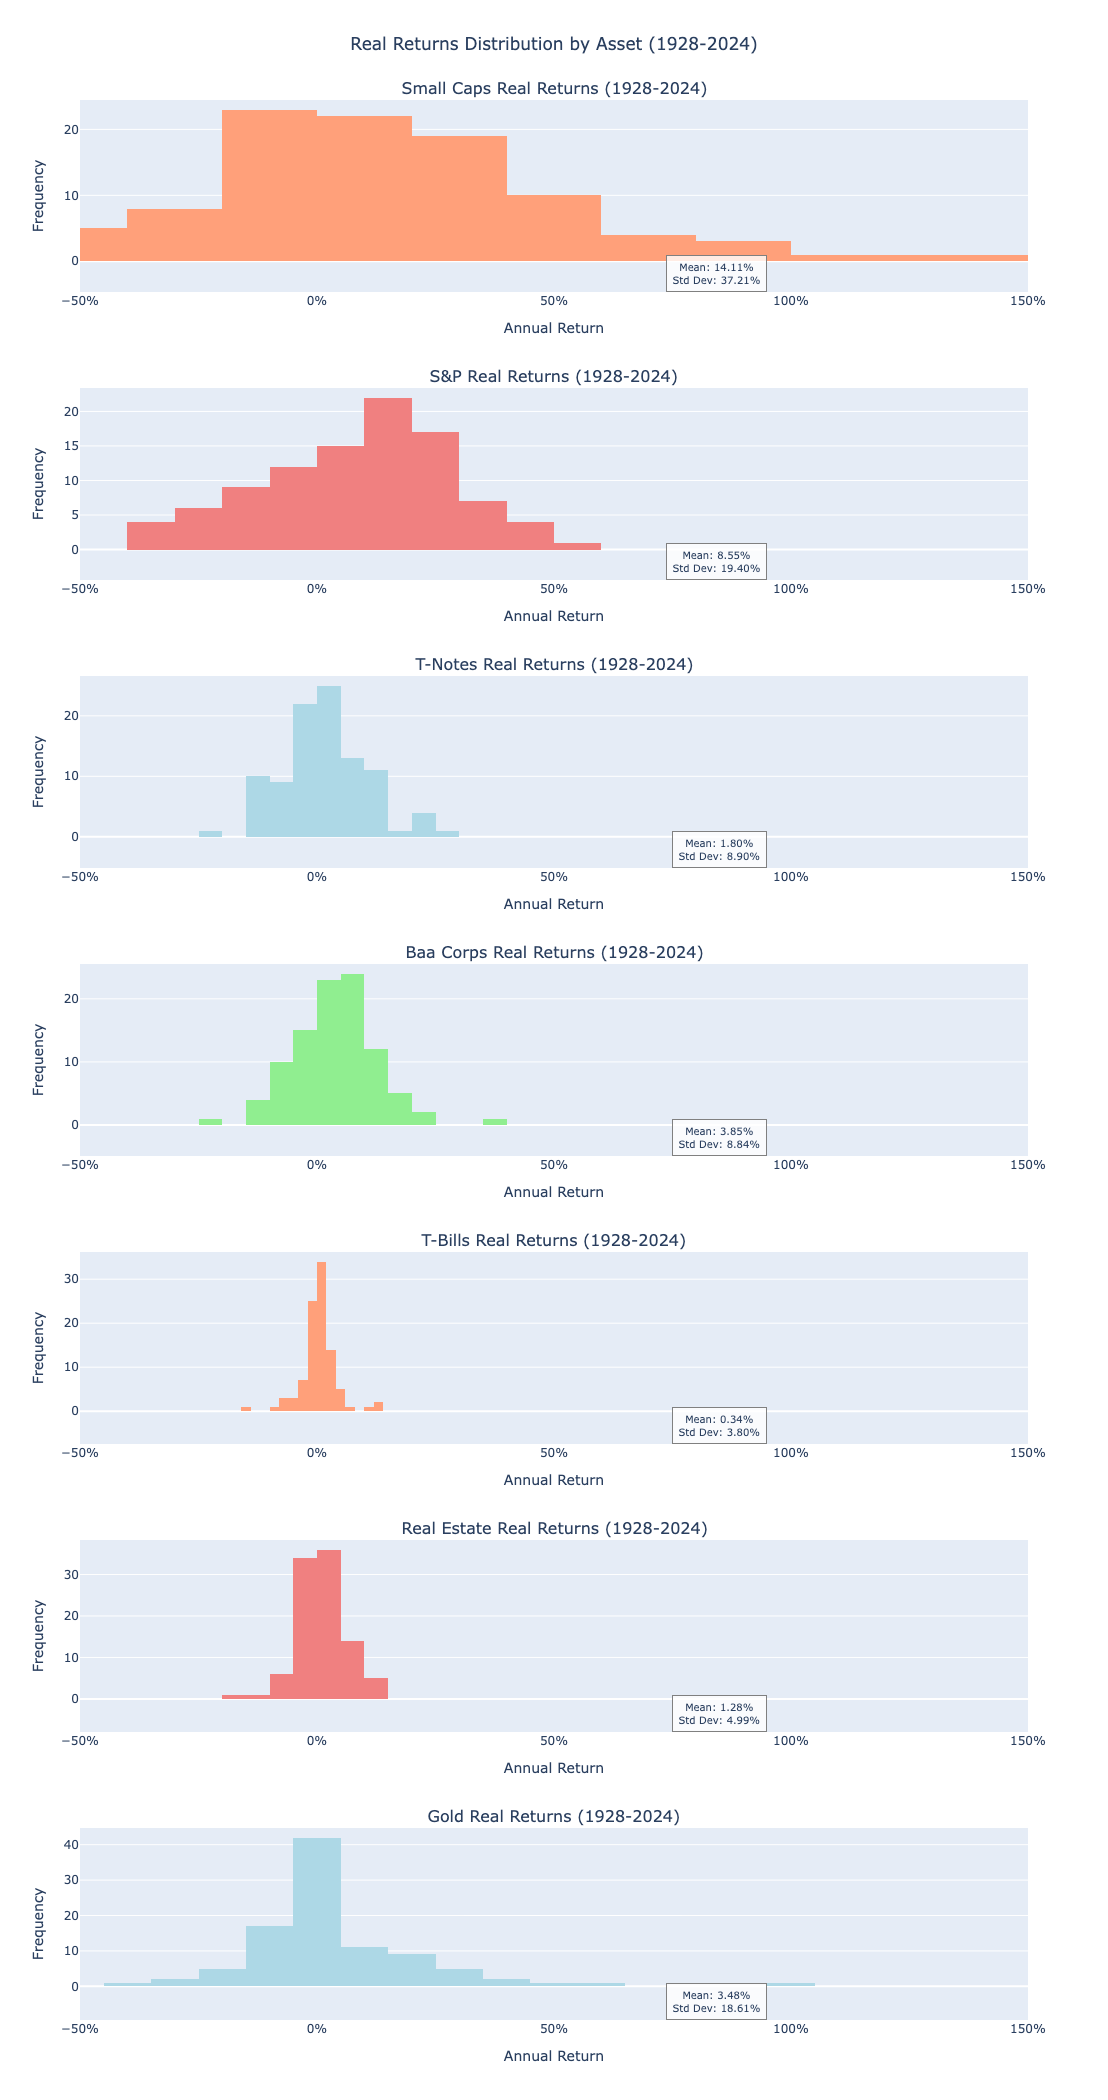

In [44]:
# Asset Real Returns Distribution (1928-2024)
# Create 7-subplot histogram showing distribution of real returns for each asset

from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Define assets and colors
assets = ['Small Caps', 'S&P', 'T-Notes', 'Baa Corps', 'T-Bills', 'Real Estate', 'Gold']
colors = ['lightsalmon', 'lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightcoral', 'lightblue']

# Create subplots (7 rows, 1 column)
fig = make_subplots(
    rows=7, cols=1,
    subplot_titles=[f'{asset} Real Returns (1928-2024)' for asset in assets],
    vertical_spacing=0.05
)

# Add histogram for each asset
for i, (asset, color) in enumerate(zip(assets, colors), start=1):
    returns = plot_returns_df[asset]
    mean_ret = returns.mean()
    std_ret = returns.std()

    # Add histogram
    fig.add_trace(
        go.Histogram(
            x=returns,
            nbinsx=15,
            name=asset,
            marker_color=color,
            showlegend=False
        ),
        row=i, col=1
    )

    # Add annotation with statistics
    fig.add_annotation(
        text=f'Mean: {mean_ret:.2%}<br>Std Dev: {std_ret:.2%}',
        xref=f'x{i}', yref=f'y{i}',
        x=0.95, y=0.95,
        xanchor='right', yanchor='top',
        showarrow=False,
        bgcolor='rgba(255, 255, 255, 0.8)',
        bordercolor='gray',
        borderwidth=1,
        borderpad=4,
        font=dict(size=10)
    )

    # Update axes with unified x-axis range
    fig.update_xaxes(title_text='Annual Return', row=i, col=1, tickformat='.0%', range=[-0.5, 1.5])
    fig.update_yaxes(title_text='Frequency', row=i, col=1)

# Update layout
fig.update_layout(
    height=2100,  # 300px per subplot
    title_text='Real Returns Distribution by Asset (1928-2024)',
    title_x=0.5,
    showlegend=False
)

fig.show()

html_str = pyo.plot(fig, include_plotlyjs='cdn', output_type='div')
pyperclip.copy( html_str)

In [22]:
# Drop CPI and GDP - not investable assets
labels = [label for label in list(plot_returns_df.columns) if label not in ['CPI', 'GDP']]

df = plot_returns_df[labels].copy()
df.head()

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,
1928,0.454932,0.617803,0.042856,0.020148,0.044268,0.026781,0.012676
1929,-0.088311,-0.469204,0.025602,0.035980,0.024189,-0.026262,-0.007258
1930,-0.200079,-0.466159,0.116932,0.116835,0.074090,0.022385,0.069359
1931,-0.380674,-0.389744,0.128213,0.074522,-0.070178,0.012861,-0.088971
1932,0.018184,0.342866,0.126429,0.212472,0.377411,-0.002145,0.351646


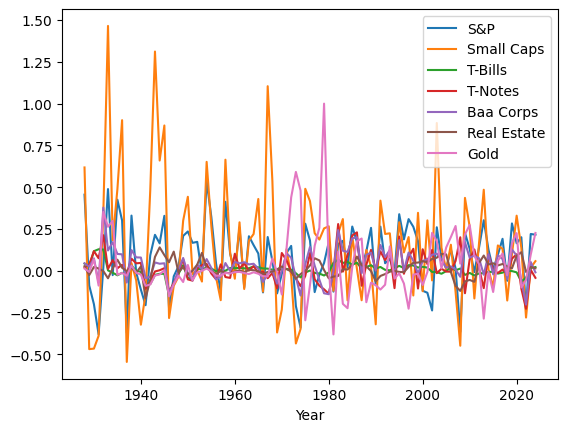

In [23]:
# Plot return series
df.plot.line();


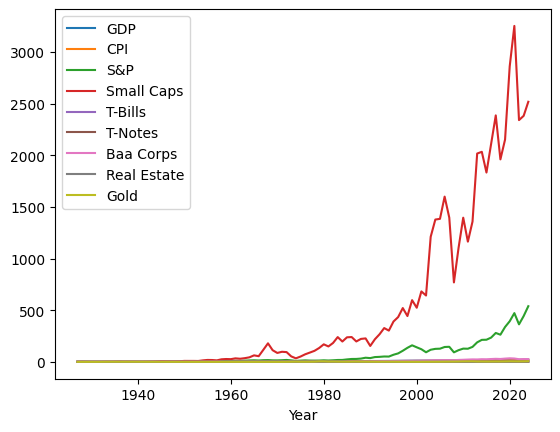

In [24]:
# Plot historical cumulative growth
total_return_index_df.plot.line();


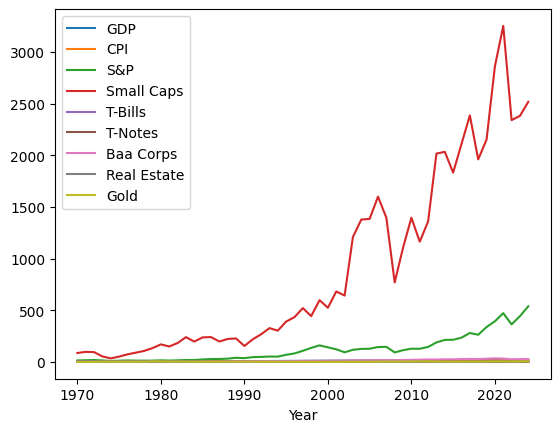

In [25]:
# plot historical cumulative growth since 1970
total_return_index_df.loc[1970:].plot.line();


# Long-only optimization

## 1928 - present 

In [26]:
df.head()


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,
1928,0.454932,0.617803,0.042856,0.020148,0.044268,0.026781,0.012676
1929,-0.088311,-0.469204,0.025602,0.035980,0.024189,-0.026262,-0.007258
1930,-0.200079,-0.466159,0.116932,0.116835,0.074090,0.022385,0.069359
1931,-0.380674,-0.389744,0.128213,0.074522,-0.070178,0.012861,-0.088971
1932,0.018184,0.342866,0.126429,0.212472,0.377411,-0.002145,0.351646


In [27]:
# Arithmetic means
df.mean()


S&P           0.085485
Small Caps    0.141127
T-Bills       0.003392
T-Notes       0.018030
Baa Corps     0.038531
Real Estate   0.012791
Gold          0.034768
dtype: float64

In [28]:
# Compute covariance matrix and optimization parameters
covariance_matrix = np.cov(df.transpose())
n_assets = covariance_matrix.shape[0]
mean_returns = df.mean().values
asset_vols = np.sqrt(covariance_matrix.diagonal())

# Display summary
summary_df = pd.DataFrame([mean_returns, asset_vols], columns=labels)
summary_df = summary_df.transpose()
summary_df.columns = ['ret', 'std']
summary_df


,ret,std
S&P,0.085485,0.193954
Small Caps,0.141127,0.372102
T-Bills,0.003392,0.038017
T-Notes,0.018030,0.088987
Baa Corps,0.038531,0.088440
Real Estate,0.012791,0.049934
Gold,0.034768,0.186131


In [29]:
# Solve max return portfolio (max return asset)
def max_return_portfolio(covariance_matrix, mean_returns, labels):
    n_assets = covariance_matrix.shape[0]
    w = cp.Variable(n_assets)
    ret = mean_returns.T @ w
    vol = cp.quad_form(w, covariance_matrix)

    prob = cp.Problem(
        cp.Maximize(ret),
        [cp.sum(w) == 1, w >= 0]
    )
    prob.solve(
        solver=cp.CLARABEL,
        tol_feas=1e-10,
        tol_gap_abs=1e-10,
        tol_gap_rel=1e-9,
        max_iter=200
    )

    if prob.status not in ['optimal', 'optimal_inaccurate']:
        raise ValueError(f"Optimization failed with status: {prob.status}")

    wts = [np.maximum(0, float(v)) for v in w.value]
    maxret1, maxretstd = compute_historical_metrics(df, np.array(wts))
    maxretvol = vol.value
    maxret = ret.value
    print(f"max variance (calculated):        {maxretstd**2}")
    print(f"max variance (from optimizer): {maxretvol}")
    print(f"max return (calculated):          {maxret1}")
    print(f"max return (from optimizer):   {maxret}")

    return maxret, maxretvol, pd.DataFrame([wts], columns=labels)

maxret, maxretvol, wts_df = max_return_portfolio(covariance_matrix, mean_returns, labels)
wts_df


max variance (calculated):        0.13845972226540204
max variance (from optimizer): 0.13845972226540204
max return (calculated):          0.14112706943428485
max return (from optimizer):   0.14112706943428482


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [30]:
# Solve min volatility portfolio (other corner solution)
# should be mostly T-bills but there is variance in t-bills so it diversifies
def min_return_portfolio(covariance_matrix, mean_returns, labels):
    n_assets = covariance_matrix.shape[0]
    w = cp.Variable(n_assets)
    ret = mean_returns.T @ w
    vol = cp.quad_form(w, covariance_matrix)

    prob = cp.Problem(
        cp.Minimize(vol),
        [cp.sum(w) == 1, w >= 0]
        )
    prob.solve(
        solver=cp.CLARABEL,
        tol_feas=1e-10,
        tol_gap_abs=1e-10,
        tol_gap_rel=1e-9,
        max_iter=200
    )

    if prob.status not in ['optimal', 'optimal_inaccurate']:
        raise ValueError(f"Optimization failed with status: {prob.status}")

    wts = [np.maximum(0, float(v)) for v in w.value]
    minvol = vol.value
    print(f"Minimum vol:        {minvol}")
    minvolret = ret.value
    print(f"Minimum vol return: {minvolret}")
    wts_df = pd.DataFrame([wts], columns=labels)
    return minvol, minvolret, wts_df 

minvol, minvolret, wts_df = min_return_portfolio(covariance_matrix, mean_returns, labels)
wts_df


Minimum vol:        0.0008313848581662196
Minimum vol return: 0.007970699337835084


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
0,0.000002,0.000074,0.600046,0.000000,0.000000,0.363039,0.036840


In [31]:
def solve_efficient_frontier(covariance_matrix, mean_returns, minvol, maxvol, NPOINTS):
    # Solve efficient frontier
    # For each volatility level, maximize return subject to volatility constraint

    # Generate volatility limits (linear spacing in std dev space, squared for variance)
    n_assets = covariance_matrix.shape[0]
    vol_std_targets = np.linspace(np.sqrt(minvol), np.sqrt(maxvol), NPOINTS)
    vol_targets = np.square(vol_std_targets)

    # Prepare parameters for parallel processing
    params_list = [(vol_limit, mean_returns, covariance_matrix, n_assets) for vol_limit in vol_targets]

    # Solve in parallel or single-thread
    if USE_PARALLEL:
        with Pool(processes=NPROCESSES) as pool:
            result_values = pool.map(solve_portfolio_optimization, params_list)
        results_dict = dict(zip(vol_targets, result_values))
    else:
        results_dict = {}
        for params in params_list:
            vol_limit = params[0]
            results_dict[vol_limit] = solve_portfolio_optimization(params)
    
    for vol_limit, result in results_dict.items():
          if result is None:
              raise ValueError(f"Optimization failed for vol_limit={vol_limit}")
          if not isinstance(result, OptimizationResult):
              raise ValueError(f"Unexpected result type for vol_limit={vol_limit}")

    # Build scenarios DataFrame
    plot_ef_df = pd.DataFrame([result.weights for result in results_dict.values()], columns=labels)
    
    plot_ef_df['model_return'] = [result.return_val for result in results_dict.values()]
    plot_ef_df['model_std'] = [result.std_dev for result in results_dict.values()]
    
    # Add historical metrics
    plot_ef_df = add_historical_metrics(plot_ef_df, df, labels)
    # weights for each asset, plus average return, standard deviation (log diff basis)
    return plot_ef_df

    
plot_ef_df=solve_efficient_frontier(covariance_matrix, mean_returns, minvol, maxretvol, NPOINTS)
plot_ef_df.head()


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold,model_return,model_std,hist_return,hist_std
0,0.000000,0.000093,0.599954,0.000000,0.000000,0.363086,0.036867,0.007974,0.028834,0.007559,0.028834
1,0.031657,0.004561,0.510481,0.000000,0.024484,0.374501,0.054316,0.012704,0.030559,0.012236,0.030559
2,0.041241,0.005535,0.456485,0.000000,0.055672,0.380567,0.060500,0.014972,0.032284,0.014451,0.032284
3,0.049049,0.006332,0.412448,0.000000,0.081113,0.385517,0.065541,0.016821,0.034009,0.016245,0.034009
4,0.055938,0.007039,0.373569,0.000000,0.103563,0.389904,0.069988,0.018454,0.035734,0.017819,0.035734


In [32]:
mean_returns = plot_ef_df[labels].mean().values
asset_vols = plot_ef_df[labels].std().values
print(asset_vols)
mean_returns

# Display summary
assets_df = pd.DataFrame([mean_returns, asset_vols], columns=labels)
assets_df = assets_df.transpose()
assets_df.columns = ['ret', 'std']
assets_df

[1.67857653e-01 3.02627469e-01 8.73666437e-02 3.70019194e-09
 1.63941264e-01 1.34828467e-01 7.55095254e-02]


,ret,std
S&P,0.323519,0.167858
Small Caps,0.370602,0.302627
T-Bills,0.022200,0.087367
T-Notes,0.000000,0.000000
Baa Corps,0.128094,0.163941
Real Estate,0.063417,0.134828
Gold,0.092168,0.075510


S&P 0.3235193350375307 0.16785765339269887
Small Caps 0.3706017211054423 0.3026274686026685
T-Bills 0.02219958405274526 0.08736664365272014
T-Notes 2.0408017737524424e-09 3.7001919436842783e-09
Baa Corps 0.12809422472456883 0.1639412639681278
Real Estate 0.06341663562385529 0.13482846679483665
Gold 0.09216849741505583 0.07550952538770644


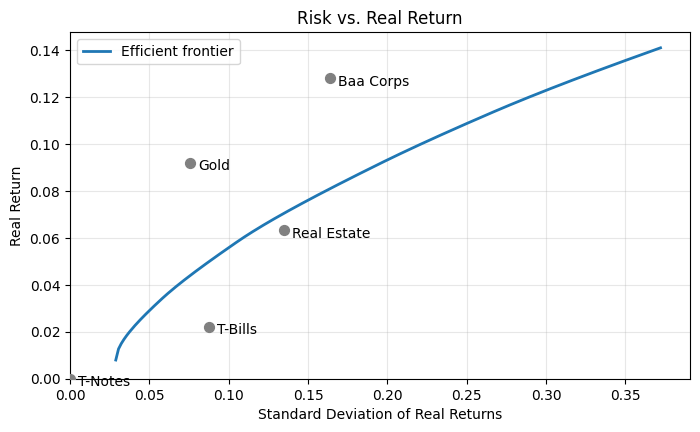

In [33]:
def efrontier(plot_ef_df,
              assets_df,
              ret_label='ret',
              std_label='std',
              xlabel="Standard Deviation of Real Returns",
              ylabel="Real Return",
              title=None,
             ):

    plt.figure(figsize=(8, 4.5))

    # Plot efficient frontier
    plt.plot(plot_ef_df[std_label], plot_ef_df[ret_label], label='Efficient frontier', linewidth=2)
    plt.xlim(left=0, right=max(plot_ef_df[std_label]) * 1.05)
    plt.ylim(bottom=min(0, min(assets_df['ret'])))   # could be negative return assets

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plot_title = f"Risk vs. Real Return" if title is None else title
    plt.title(plot_title)

    plt.scatter(assets_df['std'], assets_df['ret'], color='gray', s=50, zorder=5)

    xoffset = 0.005
    yoffset = 0.0015
    for row in assets_df.itertuples():
        print(row.Index, row.ret, row.std)
        plt.annotate(row.Index, xy=(row.std + xoffset, row.ret + yoffset),
                    xycoords='data', horizontalalignment='left',
                    verticalalignment='top')

    plt.legend(loc='best')
    plt.grid(alpha=0.3)

efrontier(plot_ef_df,
          assets_df,
          ret_label='model_return',
          std_label='model_std',
          xlabel="Standard Deviation of Real Returns",
          ylabel="Real Return",
          title=None)



In [34]:
plot_ef_df.head()

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold,model_return,model_std,hist_return,hist_std
0,0.000000,0.000093,0.599954,0.000000,0.000000,0.363086,0.036867,0.007974,0.028834,0.007559,0.028834
1,0.031657,0.004561,0.510481,0.000000,0.024484,0.374501,0.054316,0.012704,0.030559,0.012236,0.030559
2,0.041241,0.005535,0.456485,0.000000,0.055672,0.380567,0.060500,0.014972,0.032284,0.014451,0.032284
3,0.049049,0.006332,0.412448,0.000000,0.081113,0.385517,0.065541,0.016821,0.034009,0.016245,0.034009
4,0.055938,0.007039,0.373569,0.000000,0.103563,0.389904,0.069988,0.018454,0.035734,0.017819,0.035734


In [35]:
assets_df

,ret,std
S&P,0.323519,0.167858
Small Caps,0.370602,0.302627
T-Bills,0.022200,0.087367
T-Notes,0.000000,0.000000
Baa Corps,0.128094,0.163941
Real Estate,0.063417,0.134828
Gold,0.092168,0.075510


In [36]:
# use geometric mean returns based 
assets2=geometric_mean.loc[geometric_mean.index.isin(labels)].copy()
assets2.columns=['ret','std']
assets2


,ret,std
S&P,0.067000,0.193954
Small Caps,0.084081,0.372102
T-Bills,0.002675,0.038017
T-Notes,0.014209,0.088987
Baa Corps,0.034818,0.088440
Real Estate,0.011557,0.049934
Gold,0.020178,0.186131


S&P 0.06700025173582502 0.19395350634334307
Small Caps 0.08408056828456645 0.3721017633210524
T-Bills 0.002675233267664945 0.03801732106716694
T-Notes 0.014209038316325806 0.08898656237968337
Baa Corps 0.03481757315186562 0.08844045396734365
Real Estate 0.011557070650609402 0.04993371837895857
Gold 0.0201777653949613 0.18613059513248195


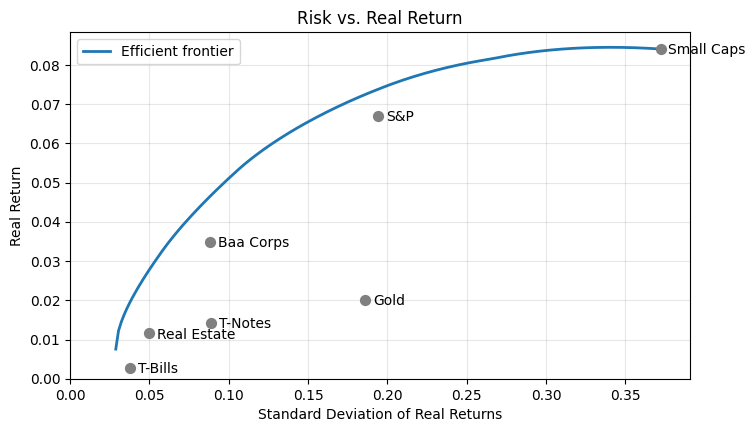

In [37]:
efrontier(plot_ef_df,
          assets2,
          ret_label='hist_return',
          std_label='hist_std',
          xlabel="Standard Deviation of Real Returns",
          ylabel="Real Return",
          title=None)


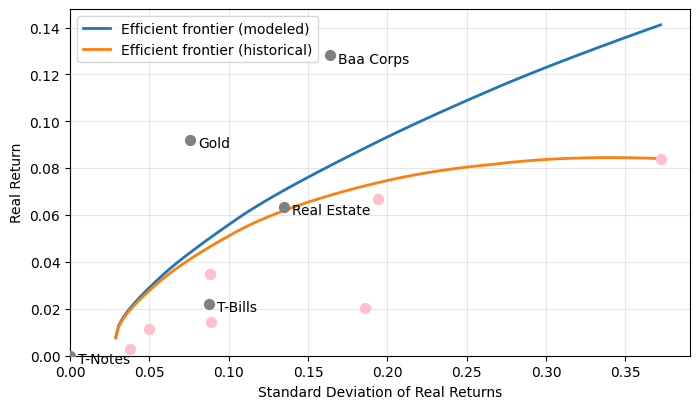

In [38]:
# plot both
title=""
plt.figure(figsize=(8, 4.5))

# Plot efficient frontier
plt.plot(plot_ef_df['model_std'], plot_ef_df['model_return'], label='Efficient frontier (modeled)', linewidth=2)
plt.plot(plot_ef_df['hist_std'], plot_ef_df['hist_return'], label='Efficient frontier (historical)', linewidth=2)

plt.xlim(left=0, right=max(plot_ef_df['model_std']) * 1.05)
plt.ylim(bottom=min(0, min(assets_df['ret'])))   # could be negative return assets

plt.xlabel("Standard Deviation of Real Returns")
plt.ylabel("Real Return")

plot_title = f"Risk vs. Real Return" if title is None else title
plt.title(plot_title)

plt.scatter(assets_df['std'], assets_df['ret'], color='gray', s=50, zorder=5)
plt.scatter(assets2['std'], assets2['ret'], color='pink', s=50, zorder=5)

xoffset = 0.005
yoffset = 0.0015
for row in assets_df.itertuples():
    # print(row.Index, row.ret, row.std)
    plt.annotate(row.Index, xy=(row.std + xoffset, row.ret + yoffset),
                xycoords='data', horizontalalignment='left',
                verticalalignment='top')

plt.legend(loc='best')
plt.grid(alpha=0.3)


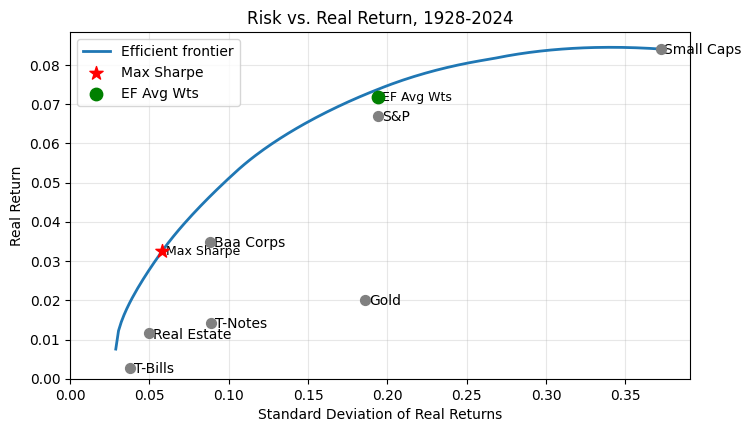

Max Sharpe Portfolio:
Real Return:  3.26%
SD:           5.82%
Sharpe Ratio: 0.561
S&P: 12.3%
Small Caps: 1.4%
Baa Corps: 32.0%
Real Estate: 43.0%
Gold: 11.3%
Average over entire efficient frontier:
Real Return:  7.18%
SD:           19.42%
Sharpe Ratio: 0.370
S&P: 32.4%
Small Caps: 37.1%
T-Bills: 2.2%
Baa Corps: 12.8%
Real Estate: 6.3%
Gold: 9.2%


In [39]:
portmetrics = plot_efrontier(plot_ef_df, plot_returns_df, assets2)


In [40]:
labels = ['S&P', 'Small Caps', 'T-Bills', 'T-Notes', 'Real Estate', 'Baa Corps', 'Gold']


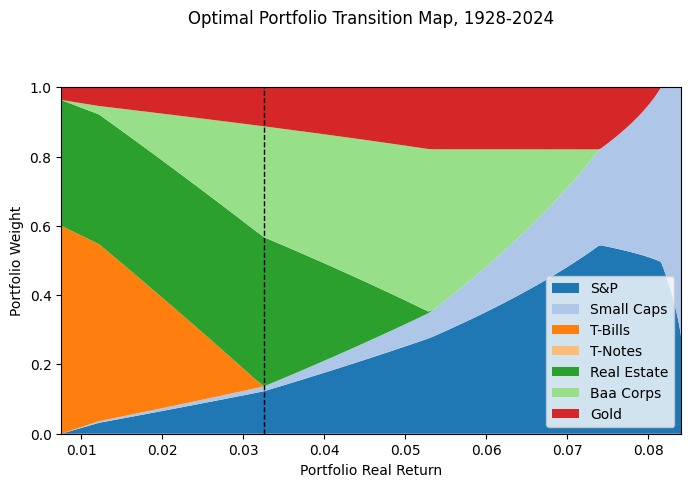

In [41]:
transition_map(plot_ef_df, asset_labels=labels,
              startyear=df.index[0], endyear=df.index[-1],
              max_sharpe_return=portmetrics.max_sharpe_return)
